# Projet d'informatique : Réseaux de neuronnes.
Par Edwin Roussin et Alexandre Partensky.

  ## Gestion de nos données

 La base de données MNIST est un ensemble d'image de chiffre de résolution 28x28, chacune accompagné de leur valeur représentée sous forme d'un entier ou d'un vecteur. Après avoir téléchargé la base de données, nous l'ouvrons à l'aide d'un code que nous avons repris sur Github.

> Lien base MNIST : http://yann.lecun.com/exdb/mnist/



> Lien github : https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/mnist_loader.py



  Les images sont triées selon deux groupes. Le premier, appelé "training_data" permet d'entrainer l'algorithme de machine learning à reconnaître les images. Le second, "test_data" permet de tester la capacité de l'algorithme à reconnaître des images, une fois que celui-ci à été entrainé sur les images d'entraînements. Ces deux objets sont importés sous forme de liste de couple, chaque couple représentant une image avec l'ensemble des valeurs des pixels pour la première composante et la traduction de la valeur de l'image pour la seconde composante. Pour le test_data, la valeur de chaque image (deuxième composante du tuple) est un nombre tandis que c'est une liste sous la forme $np.array([0,1,0,0,0,0,0,0,0,0])$ pour le trainig_data. La fonction "vectorized_result" permet de passer de la première représentation à la deuxième si besoin.
  
Il existe également un validation_data utilisé de manière intermédiaire dans la phase d'entrainement qui comporte moins de données que le test_data. Il est surtout utile pour calibrer les hyperparamètres du réseau, prévenir l'over-fitting et mettre en place des early-stopping par exemple.

In [ ]:
#importation des données MNIST
import pickle
import gzip

import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()

On importe d'abord les librairies nécessaires à la construction de notre réseau.

In [ ]:
import numpy as np
import random
from tqdm import tqdm #sert à visualiser l'avancement des calculs lorsqu'on lance le programme
import matplotlib.pyplot as plt

On définit deux fonctions, $sigmoid$ et $sigmoid$_$prime$. La fonction $sigmoid$ est la fonction d'activation de notre réseau. Elle est valeur de sortie d'un neuronne à partir d'une valeur d'entrée $z$ calculé selon les poids et les biais propre au neuronne. Elle est bijective sur $R$ à valeur dans $[0;1]$. 

La fonction $sigmoid$_$prime$ renvoie sa dérivée, ce qui est utile pour la descente de gradient.


In [ ]:
def sigmoid(z):
  return 1/(1+np.exp(-z)) # ATTENTION peut valoir 0 ou 1 dans python 

def sigmoid_prime(z): #dérivé de la fonction sigmoid
  return sigmoid(z)*(1-sigmoid(z))

On construit alors le réseau à l'aide de la classe "Network".

## Description du type de neuronne utilisé

Le neuronne utilisé est classique.

Pour une liste d'entrée  $ (e_{1},e_{2},e_{3},...,e_{n})$, Il définit en entier $z$ tel que 

$z = w_{1}×e_{1} + w_{2}×e_{2} + ... + w_{n}×e_{n} + b $

avec $(w_{1},w_{2},w_{3},...,w_{n})$ l'ensemble des "poids" associé à un neuronne et $b$ le biais du neuronne. 

On compose ensuite z par la fonction d'activation sigmoid définie ci-dessus. Le neuronne renvoie alors sigmoid(z). 

Pour une couche de neuronnes, prenant en entrée $E = (e_{1},e_{2},e_{3},...,e_{n})$, on peut calculer la valeur de sortie sous forme d'un vecteur $A$ tel que 

$A = sigmoid(Z) = W·E + B $

avec $A$ est le vecteur d'activation de la couche en question, $W$ la matrice des poids des neuronnes de la couche, dont chaque ligne est l'ensemble des poids d'un seul neuronne et $B$ le vecteur des biais des neuronnes de la couche

$A = sigmoid(Z)$ est le vecteur de sortie de la couche de neuronne dont les composantes sont $(sigmoid(z_{1}),sigmoid(z_{2}),...,sigmoid(z_{n})$.

### Description des attributs :

La classe contient 6 attributs :

- **num_layers** est le nombre de couche de neuronnes de notre réseau
>**Par soucis de simplicité, nous décidons d'utiliser uniquement un réseau de neuronnes avec 3 couches, une pour les entrées, une au milieu et une pour les sorties**.
- **sizes** est un tableau de taille num_layers et dont la i-ème case est le nombre de neuronnes dans la i-ème couche du réseau.

- **biaises** est la liste des vecteurs des biais de chaque couche de neuronnes.

- **weights** est la liste des matrices des poids de chaque couche de neuronnes.

- **train_cost** est la liste des costs sur le train set lors de l'entraînements.

- **test_cost** est la liste des costs sur le test set lors de l'entraînement
- **acc** la liste donnant l'accuracy du réseau sur le test set au fur et à mesure de l'entraînement


### Description des premières méthodes :

- **init** correspond à l'initialisation de la classe, elle prend en argument la taille de réseaux, soit une liste de longueur variable dont la valeur de la i-ième case est le nombre de neuronne de la i-ème couche.

 Elle prend également en argument, si spécifié, une classe Cost. Cela permet de tester différentes fonctions coût. Nous avons par exemple rajouté la fonction log_loss à notre réseaux. Cela permet d'accéler l'apprentissage surtout au début si le score est très mauvais.

>La première couche, comporte $28*28 = 784$ entrées, soit une par pixel.

>La dernière couche, comporte 10 sorties, la valeur de la i-ème sortie est la probabilité que le chiffre soit égal à i, elle est donc comprise entre 0 et 1 (la fonction sigmoïd est bien à valeur dans $[0;1]$). 
Pour intépreter ce résultat, on considère que le chiffre choisis par l'algorithme est celui dont la probabilité est la plus élévée. 

>Comme nous décidons d'utiliser un réseau avec seulement 3 couches, on n'utilise $init$ uniquement avec un tableau de taille 3.


- **vectorized_result** transforme un chiffre en une représentation sous forme de vecteur qui est semblable à celle de sortie du réseau. Le chiffre i est renvoyé sous la forme d'un vecteur de taille 10 dont toutes les composantes sont nulles sauf la i-ème qui vaut 1. 

- **feedforward** prend en argument la liste des pixels d'une image et renvoie à l'aide d'une suite de calculs matriciels le vecteur de sortie de notre réseau. 

- **accuracy** prend en argument la liste d'image test_data et renvoie le taux de succes de l'algorithme de reconnaissance ainsi que le cost total.



- **progression**  affiche avec des graphes l'erreur cumulée et la précision du réseau de neuronnes.



>On définit une nouvelle classe à chaque fois qu'on souhaite utiliser une nouvelle fonciton coût. Ici il y a le classique QuadraticCost ainsi que la CrossEntropyCost. Pour chaque coût on implémente la fonction coût en elle même ainsi que la fonction delta qui dépend mathématiquement de la dérivée de la fonction coût. 

>La différence majeure entre les deux est que le delta pour la fonction log loss ne dépend plus de $sigma$_$prime(z)$ qui peut être très faible alors que le reseaux se trompent complétement. Ainsi on est assuré que delta ne sera jamais trop petit lorsque l'output du reseau est très différent de la réponse attendu, ce qui n'était pas le cas avec le QuadraticCost.

In [ ]:
class QuadraticCost(object):
    @staticmethod
    def cost(a, y):
      if type(y) == np.int64 :
        y = vectorized_result(y)
      return 0.5*np.linalg.norm(a-y)**2
    @staticmethod
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def cost(a, y):
      if type(y) == np.int64 :
        y = vectorized_result(y)
      return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        return (a-y)

### Description des méthodes relatives à l'apprentissage du réseau de neuronnes : 

- **SGD** est la méthode qui excécute l'apprentissage de notre réseau de neurones.

Elle prend donc "training_data" en premier argument. 
"nb_training" est le nombre de fois que le programme répétera l'apprentissage sur l'ensemble du "training_data".

Lors de l'apprentisssage celui-ci est divisé un nombre de lots (batch) de taille batch_size (troisième argument). Le reseau de neurone apprendra ainsi batch après batch.

"eta" est le learning rate, un des hyperparamètres de notre réseau, qui comme son nom l'indique peut de manière analogique est  vue comme une vitesse d'apprentissage du  réseau.

Enfin "test_data" permet entre chaque entraînement sur le "training_data" d'observer l'évolution des performances de l'algorithme sur des données en dehors du set d'apprentissage.

En particulier, SGD divise le l'ensemble des images de training_data en différents lots. Lorsque l'algorithme finit de parcourir un lot, SGD appelle la méthode **update_batch** qui va modifier les weights et les biaises du réseau selon la méthode de descente de gradient obtenue par la méthode **backprop**. 

Séparer en différents lots permet d'éviter que l'algorithme apprenne à chaque image et donc que le temps d'exécution du programme ne soit trop long.

- **update_batch** est une méthode appelée par SGD, qui permet l'apprentissage du réseau lorsqu'on lui fait parcourir un lot d'image. Elle prend donc en argument un batch, et eta, la vitesse d'apprentissage. Pour chaque élément du batch, elle récolte dw et db, soit les modifications du réseau nécéssaire, obtenue par la méthode de descente de gradient et calculé ici par la méthode **backprop**. Elle en fait une moyenne et modifie adéquatement les valeurs de weights et biaises. Plus eta est élevé, plus la modification sera importante.

- **backprop** est une méthode qui prend en argument une image, donc ici la liste de valeur de ses pixels et le nombre qu'elle représente.*La méthode calcule d'abord l'output du réseau pour cette image qui est un vecteur numpy de taille 10 avec des nombre dans $[0,1]$.

 Elle calcule ensuite, selon la méthode de descente du gradient, dw et db, qui sont les modifications qu'il faut apporter au réseaux de neuronnes afin de faire baisser le coût de manière optimale.
 
 La méthode utilisé s'appelle backpropagation. L'idéee générale est de d'abord calculer les dérivées partielles de C (fonction coût quelconque) par rapport au biais et poids de la dernière couche, puis grâce à ces valeurs de calculer les valeurs de la couche précendete etc jusqu'à tous les connaîtres.


Les équations utilisées pour la backpropagation sont les suivantes :

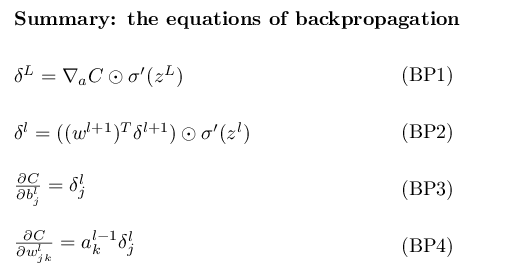


In [ ]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt


def sigmoid(z):
  return 1/(1+np.exp(-z)) # ATTENTION peut valoir 0 ou 1 dans python 

def sigmoid_prime(z): #dérivé de la fonction sigmoid
  return sigmoid(z)*(1-sigmoid(z))

class Network(object):

    def __init__(self, sizes,  Cost = CrossEntropyCost): #sizes = [784,_,10] = [taille_data, taille_layer_1, output_layer]
        self.num_layers = len(sizes)-1
        self.sizes = sizes
        self.cost = Cost
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.train_cost = []
        self.test_cost = []
        self.acc = []
        #initialize biases and weights randomly

    
    def feedforward(self, value):
        for i in range(self.num_layers):
           value = sigmoid(np.dot(self.weights[i],value) + self.biases[i])
        return value

    # Test unitaire : 

    def test_feedforward(self): #vérifie que feedforward() renvoie bien le type de valeur souhaité
      data = np.ones((784,1))
      result = self.feedforward(data)
      return np.shape(result) == (10,1) and np.max(result) <= 1 and np.min(result)>=0


    def accuracy(self, test_data):
      total = 10000 
      sucess = 0
      cost = 0
      for (value,number) in test_data :
        a = self.feedforward(value)
        if np.argmax(a) == number :
          sucess +=1
        cost += (self.cost).cost(a,number)
      return sucess/total, cost/total
 
    
    def SGD(self,training_data, nb_training, batch_size, eta, test_data = None):
      training_data = list(training_data)
      n = len(training_data) 
      self.test_cost.append(batch_size) # store value of batch_size for progression()
      self.test_cost.append(n) # store value of len(training_data) for progression()
      for j in tqdm(range(nb_training)):
          random.shuffle(training_data)
          if n%batch_size == 0 :
              batches = [training_data[i:i + batch_size] for i in range(0,n-batch_size+1, batch_size)]
          else :
              batches = [training_data[i:i + batch_size] for i in range(0,n-batch_size+1, batch_size)] + [training_data[n-n%batch_size:]]
          for batch in (batches):
              self.update_batch(batch, eta)
          if test_data :
              test_data = list(test_data)
              acc , mean_cost = self.accuracy(test_data)
              self.test_cost.append(mean_cost)
              self.acc.append(acc)
              print("Accuracy de {}% après {} entraînement(s)".format(100*acc, j+1))
              
    def update_batch(self, batch, eta):
        
        m = len(batch)
        sum_dw = [np.zeros((y, x)) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        sum_db = [np.zeros((y, 1)) for y in self.sizes[1:]]
        batch_cost = 0
        for value,number in batch :
            list_dw, list_db, cost = self.backprop(value, number)
            sum_dw = [w + dw for w,dw in zip(sum_dw,list_dw)] 
            sum_db = [b + db for b,db in zip(sum_db,list_db)] 
            batch_cost += cost
        
        self.weights = [w-(eta/m)*dw for w,dw in zip(self.weights,sum_dw)]
        self.biases = [b-(eta/m)*db for b,db in zip(self.biases,sum_db)]
        self.train_cost.append(batch_cost/m)

    def backprop(self, value, number):
        
      z = [np.zeros((y, 1)) for y in self.sizes[1:]]
      db = [np.zeros((y, 1)) for y in self.sizes[1:]]
      dw = [np.zeros((y, x)) for x, y in zip(self.sizes[:-1], self.sizes[1:])]            
      output = value
      a = [value]
      
      for i in range(self.num_layers):
        z[i] = np.dot(self.weights[i],output) + self.biases[i]
        output = sigmoid(z[i])
        a.append(output)
      cost = (self.cost).cost(output, number)
      delta = (self.cost).delta(z[-1], output, number)
      db[-1] = delta
      dw[-1] = np.outer(delta,a[-2])
      
      for j in range(2,self.num_layers+1):
        delta = np.dot(np.transpose(self.weights[-j+1]),delta) * sigmoid_prime(z[-j])
        db[-j] = delta
        dw[-j] = np.outer(delta,a[-j-1])
      return (dw,db,cost)
  
    def progression(self):
        batch_size, nb_data = self.test_cost.pop(0), self.test_cost.pop(0)
        train_cost_by_training = self.train_cost[::nb_data//batch_size]
        plt.subplot(1, 2, 1)
        plt.xlabel("Nb of trainings")
        plt.plot(self.test_cost, label = 'test_cost')
        plt.plot(train_cost_by_training, label = 'train_cost')
        plt.legend()
        plt.title("Costs over trainings")
        plt.subplot(1, 2, 2)
        plt.xlabel("Nb of trainings")
        plt.plot(self.acc)
        plt.title("Accuracy")
        plt.suptitle("Performance")
        plt.show()


La cellule suivante affiche les graphes des costs et de la précision obtenus à chaque apprentissage du réseau de neuronnes. On voit bien que l'erreur tend à décroître et que la précision est strictement croissante comme attendu. L'accuracy obtenu après 10 phases d'entraînements est de 95% et ne progresse que très lentement à partir de cette valeur. Entraîner plus le réseau nous expose alors à des risques d'overfitting.

 10%|█         | 1/10 [00:13<02:02, 13.66s/it]

Accuracy de 81.27% après 1 entraînement(s)


 20%|██        | 2/10 [00:27<01:49, 13.74s/it]

Accuracy de 88.33% après 2 entraînement(s)


 30%|███       | 3/10 [00:41<01:36, 13.73s/it]

Accuracy de 89.97% après 3 entraînement(s)


 40%|████      | 4/10 [00:54<01:21, 13.66s/it]

Accuracy de 90.75999999999999% après 4 entraînement(s)


 50%|█████     | 5/10 [01:08<01:08, 13.71s/it]

Accuracy de 91.36% après 5 entraînement(s)


 60%|██████    | 6/10 [01:22<00:55, 13.78s/it]

Accuracy de 91.62% après 6 entraînement(s)


 70%|███████   | 7/10 [01:36<00:41, 13.74s/it]

Accuracy de 91.96% après 7 entraînement(s)


 80%|████████  | 8/10 [01:49<00:27, 13.76s/it]

Accuracy de 92.21000000000001% après 8 entraînement(s)


 90%|█████████ | 9/10 [02:05<00:14, 14.28s/it]

Accuracy de 92.43% après 9 entraînement(s)


100%|██████████| 10/10 [02:19<00:00, 13.91s/it]

Accuracy de 92.60000000000001% après 10 entraînement(s)


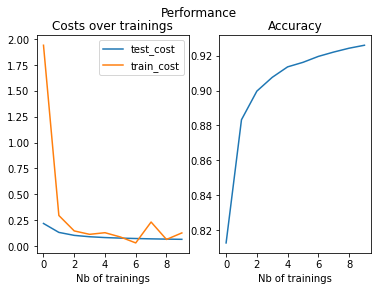

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()

net_0 = Network([784,30,10], QuadraticCost)
net_0.test_feedforward()

net_0.SGD(training_data, 10, 10, 0.05, test_data) 
net_0.progression()

  1%|          | 1/100 [00:17<28:33, 17.31s/it]

Accuracy de 85.41% après 1 entraînement(s)


  2%|▏         | 2/100 [00:34<28:33, 17.48s/it]

Accuracy de 89.5% après 2 entraînement(s)


  3%|▎         | 3/100 [00:52<28:16, 17.49s/it]

Accuracy de 90.23% après 3 entraînement(s)


  4%|▍         | 4/100 [01:09<27:46, 17.36s/it]

Accuracy de 91.03999999999999% après 4 entraînement(s)


  5%|▌         | 5/100 [01:27<27:34, 17.42s/it]

Accuracy de 91.39% après 5 entraînement(s)


  6%|▌         | 6/100 [01:44<27:18, 17.43s/it]

Accuracy de 91.71000000000001% après 6 entraînement(s)


  7%|▋         | 7/100 [02:01<26:53, 17.35s/it]

Accuracy de 91.89% après 7 entraînement(s)


  8%|▊         | 8/100 [02:19<26:36, 17.35s/it]

Accuracy de 92.08% après 8 entraînement(s)


  9%|▉         | 9/100 [02:36<26:18, 17.34s/it]

Accuracy de 92.36% après 9 entraînement(s)


 10%|█         | 10/100 [02:53<25:51, 17.24s/it]

Accuracy de 92.51% après 10 entraînement(s)


 11%|█         | 11/100 [03:12<26:15, 17.70s/it]

Accuracy de 92.69% après 11 entraînement(s)


 12%|█▏        | 12/100 [03:29<25:45, 17.56s/it]

Accuracy de 92.91% après 12 entraînement(s)


 13%|█▎        | 13/100 [03:46<25:16, 17.44s/it]

Accuracy de 93.02% après 13 entraînement(s)


 14%|█▍        | 14/100 [04:03<24:55, 17.39s/it]

Accuracy de 93.21000000000001% après 14 entraînement(s)


 15%|█▌        | 15/100 [04:21<24:33, 17.34s/it]

Accuracy de 93.31% après 15 entraînement(s)


 16%|█▌        | 16/100 [04:38<24:13, 17.30s/it]

Accuracy de 93.49% après 16 entraînement(s)


 17%|█▋        | 17/100 [04:55<23:55, 17.29s/it]

Accuracy de 93.57% après 17 entraînement(s)


 18%|█▊        | 18/100 [05:12<23:33, 17.23s/it]

Accuracy de 93.7% après 18 entraînement(s)


 19%|█▉        | 19/100 [05:30<23:21, 17.30s/it]

Accuracy de 93.82000000000001% après 19 entraînement(s)


 20%|██        | 20/100 [05:47<23:01, 17.27s/it]

Accuracy de 93.89% après 20 entraînement(s)


 21%|██        | 21/100 [06:04<22:40, 17.22s/it]

Accuracy de 93.89999999999999% après 21 entraînement(s)


 22%|██▏       | 22/100 [06:21<22:23, 17.22s/it]

Accuracy de 94.01% après 22 entraînement(s)


 23%|██▎       | 23/100 [06:39<22:10, 17.28s/it]

Accuracy de 94.03% après 23 entraînement(s)


 24%|██▍       | 24/100 [06:56<21:56, 17.32s/it]

Accuracy de 94.19999999999999% après 24 entraînement(s)


 25%|██▌       | 25/100 [07:15<22:17, 17.83s/it]

Accuracy de 94.23% après 25 entraînement(s)


 26%|██▌       | 26/100 [07:32<21:50, 17.71s/it]

Accuracy de 94.33% après 26 entraînement(s)


 27%|██▋       | 27/100 [07:50<21:25, 17.61s/it]

Accuracy de 94.39999999999999% après 27 entraînement(s)


 28%|██▊       | 28/100 [08:07<21:01, 17.52s/it]

Accuracy de 94.39% après 28 entraînement(s)


 29%|██▉       | 29/100 [08:25<20:43, 17.52s/it]

Accuracy de 94.52000000000001% après 29 entraînement(s)


 30%|███       | 30/100 [08:42<20:18, 17.41s/it]

Accuracy de 94.62% après 30 entraînement(s)


 31%|███       | 31/100 [08:59<20:04, 17.45s/it]

Accuracy de 94.62% après 31 entraînement(s)


 32%|███▏      | 32/100 [09:17<19:43, 17.40s/it]

Accuracy de 94.62% après 32 entraînement(s)


 33%|███▎      | 33/100 [09:34<19:24, 17.38s/it]

Accuracy de 94.65% après 33 entraînement(s)


 34%|███▍      | 34/100 [09:52<19:11, 17.44s/it]

Accuracy de 94.6% après 34 entraînement(s)


 35%|███▌      | 35/100 [10:09<18:50, 17.39s/it]

Accuracy de 94.67999999999999% après 35 entraînement(s)


 36%|███▌      | 36/100 [10:26<18:28, 17.32s/it]

Accuracy de 94.72% après 36 entraînement(s)


 37%|███▋      | 37/100 [10:43<18:13, 17.36s/it]

Accuracy de 94.67999999999999% après 37 entraînement(s)


 38%|███▊      | 38/100 [11:01<18:01, 17.45s/it]

Accuracy de 94.73% après 38 entraînement(s)


 39%|███▉      | 39/100 [11:20<18:15, 17.96s/it]

Accuracy de 94.91000000000001% après 39 entraînement(s)


 40%|████      | 40/100 [11:38<17:46, 17.77s/it]

Accuracy de 94.81% après 40 entraînement(s)


 41%|████      | 41/100 [11:55<17:21, 17.65s/it]

Accuracy de 94.98% après 41 entraînement(s)


 42%|████▏     | 42/100 [12:12<16:53, 17.47s/it]

Accuracy de 94.82000000000001% après 42 entraînement(s)


 43%|████▎     | 43/100 [12:29<16:29, 17.36s/it]

Accuracy de 94.78% après 43 entraînement(s)


 44%|████▍     | 44/100 [12:47<16:14, 17.41s/it]

Accuracy de 94.89999999999999% après 44 entraînement(s)


 45%|████▌     | 45/100 [13:04<15:54, 17.36s/it]

Accuracy de 94.94% après 45 entraînement(s)


 46%|████▌     | 46/100 [13:21<15:32, 17.27s/it]

Accuracy de 94.99% après 46 entraînement(s)


 47%|████▋     | 47/100 [13:38<15:16, 17.30s/it]

Accuracy de 95.03% après 47 entraînement(s)


 48%|████▊     | 48/100 [13:55<14:56, 17.25s/it]

Accuracy de 95.07% après 48 entraînement(s)


 49%|████▉     | 49/100 [14:13<14:39, 17.24s/it]

Accuracy de 95.03% après 49 entraînement(s)


 50%|█████     | 50/100 [14:30<14:22, 17.25s/it]

Accuracy de 95.04% après 50 entraînement(s)


 51%|█████     | 51/100 [14:47<14:04, 17.24s/it]

Accuracy de 95.1% après 51 entraînement(s)


 52%|█████▏    | 52/100 [15:04<13:46, 17.23s/it]

Accuracy de 95.17999999999999% après 52 entraînement(s)


 53%|█████▎    | 53/100 [15:23<13:52, 17.70s/it]

Accuracy de 95.23% après 53 entraînement(s)


 54%|█████▍    | 54/100 [15:40<13:28, 17.57s/it]

Accuracy de 95.26% après 54 entraînement(s)


 55%|█████▌    | 55/100 [15:58<13:05, 17.46s/it]

Accuracy de 95.25% après 55 entraînement(s)


 56%|█████▌    | 56/100 [16:15<12:46, 17.42s/it]

Accuracy de 95.27% après 56 entraînement(s)


 57%|█████▋    | 57/100 [16:32<12:27, 17.39s/it]

Accuracy de 95.36% après 57 entraînement(s)


 58%|█████▊    | 58/100 [16:51<12:30, 17.87s/it]

Accuracy de 95.3% après 58 entraînement(s)


 59%|█████▉    | 59/100 [17:09<12:05, 17.70s/it]

Accuracy de 95.34% après 59 entraînement(s)


 60%|██████    | 60/100 [17:26<11:42, 17.56s/it]

Accuracy de 95.41% après 60 entraînement(s)


 61%|██████    | 61/100 [17:43<11:22, 17.50s/it]

Accuracy de 95.39999999999999% après 61 entraînement(s)


 62%|██████▏   | 62/100 [18:00<11:01, 17.40s/it]

Accuracy de 95.48% après 62 entraînement(s)


 63%|██████▎   | 63/100 [18:18<10:41, 17.35s/it]

Accuracy de 95.45% après 63 entraînement(s)


 64%|██████▍   | 64/100 [18:35<10:25, 17.37s/it]

Accuracy de 95.44% après 64 entraînement(s)


 65%|██████▌   | 65/100 [18:52<10:07, 17.36s/it]

Accuracy de 95.49% après 65 entraînement(s)


 66%|██████▌   | 66/100 [19:12<10:09, 17.92s/it]

Accuracy de 95.52000000000001% après 66 entraînement(s)


 67%|██████▋   | 67/100 [19:29<09:45, 17.74s/it]

Accuracy de 95.52000000000001% après 67 entraînement(s)


 68%|██████▊   | 68/100 [19:46<09:23, 17.62s/it]

Accuracy de 95.52000000000001% après 68 entraînement(s)


 69%|██████▉   | 69/100 [20:04<09:04, 17.55s/it]

Accuracy de 95.54% après 69 entraînement(s)


 70%|███████   | 70/100 [20:21<08:44, 17.50s/it]

Accuracy de 95.61% après 70 entraînement(s)


 71%|███████   | 71/100 [20:40<08:41, 17.97s/it]

Accuracy de 95.63000000000001% après 71 entraînement(s)


 72%|███████▏  | 72/100 [20:57<08:16, 17.74s/it]

Accuracy de 95.67% après 72 entraînement(s)


 73%|███████▎  | 73/100 [21:14<07:54, 17.57s/it]

Accuracy de 95.67999999999999% après 73 entraînement(s)


 74%|███████▍  | 74/100 [21:32<07:34, 17.50s/it]

Accuracy de 95.59% après 74 entraînement(s)


 75%|███████▌  | 75/100 [21:49<07:16, 17.47s/it]

Accuracy de 95.75% après 75 entraînement(s)


 76%|███████▌  | 76/100 [22:06<06:58, 17.44s/it]

Accuracy de 95.7% après 76 entraînement(s)


 77%|███████▋  | 77/100 [22:24<06:40, 17.43s/it]

Accuracy de 95.65% après 77 entraînement(s)


 78%|███████▊  | 78/100 [22:41<06:23, 17.42s/it]

Accuracy de 95.67999999999999% après 78 entraînement(s)


 79%|███████▉  | 79/100 [22:59<06:04, 17.37s/it]

Accuracy de 95.72% après 79 entraînement(s)


 80%|████████  | 80/100 [23:18<05:57, 17.89s/it]

Accuracy de 95.67% après 80 entraînement(s)


 81%|████████  | 81/100 [23:35<05:35, 17.67s/it]

Accuracy de 95.69% après 81 entraînement(s)


 82%|████████▏ | 82/100 [23:52<05:14, 17.48s/it]

Accuracy de 95.73% après 82 entraînement(s)


 83%|████████▎ | 83/100 [24:09<04:54, 17.34s/it]

Accuracy de 95.72% après 83 entraînement(s)


 84%|████████▍ | 84/100 [24:26<04:36, 17.29s/it]

Accuracy de 95.78% après 84 entraînement(s)


 85%|████████▌ | 85/100 [24:44<04:24, 17.63s/it]

Accuracy de 95.78999999999999% après 85 entraînement(s)


 86%|████████▌ | 86/100 [25:01<04:03, 17.41s/it]

Accuracy de 95.77% après 86 entraînement(s)


 87%|████████▋ | 87/100 [25:18<03:44, 17.27s/it]

Accuracy de 95.84% après 87 entraînement(s)


 88%|████████▊ | 88/100 [25:35<03:26, 17.24s/it]

Accuracy de 95.83% après 88 entraînement(s)


 89%|████████▉ | 89/100 [25:52<03:08, 17.14s/it]

Accuracy de 95.77% après 89 entraînement(s)


 90%|█████████ | 90/100 [26:09<02:50, 17.06s/it]

Accuracy de 95.71% après 90 entraînement(s)


 91%|█████████ | 91/100 [26:26<02:32, 16.99s/it]

Accuracy de 95.77% après 91 entraînement(s)


 92%|█████████▏| 92/100 [26:43<02:15, 16.95s/it]

Accuracy de 95.87% après 92 entraînement(s)


 93%|█████████▎| 93/100 [27:01<02:01, 17.33s/it]

Accuracy de 95.87% après 93 entraînement(s)


 94%|█████████▍| 94/100 [27:20<01:45, 17.66s/it]

Accuracy de 95.88% après 94 entraînement(s)


 95%|█████████▌| 95/100 [27:37<01:27, 17.53s/it]

Accuracy de 95.92% après 95 entraînement(s)


 96%|█████████▌| 96/100 [27:54<01:09, 17.30s/it]

Accuracy de 95.89999999999999% après 96 entraînement(s)


 97%|█████████▋| 97/100 [28:10<00:51, 17.17s/it]

Accuracy de 95.88% après 97 entraînement(s)


 98%|█████████▊| 98/100 [28:27<00:34, 17.12s/it]

Accuracy de 95.89999999999999% après 98 entraînement(s)


 99%|█████████▉| 99/100 [28:45<00:17, 17.42s/it]

Accuracy de 95.95% après 99 entraînement(s)


100%|██████████| 100/100 [29:02<00:00, 17.43s/it]

Accuracy de 95.91% après 100 entraînement(s)


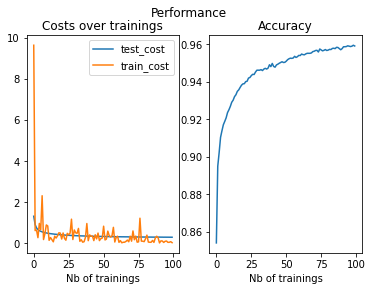

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()

net = Network([784,30,10])
net.test_feedforward()


net.SGD(training_data, 100, 10, 0.01, test_data)
net.progression()